# Primer uporabe vizualizacije za tabelarične podatke
V tem zvezku demonstriramo delovanje metode za raziskovanje poljubnih projekcij tabelaričnih podatkov.

In [1]:
import sys 
sys.path.append('..')

from lib.tab_exploration.tab_explorer import TabExplorer, GiniExplorer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import mlab
np.random.seed(1)
%matplotlib inline

In [2]:
def save_plot(fname, fig=None, show_axis=False):
    if fig is None:
        fig = plt.gcf()
    
    if not show_axis:
        axs = fig.axes
        for ax in axs:
            ax.axis('off')
    fig.savefig(fname, bbox_inches='tight')

Za demonstracijo uporabimo podatke o ljudeh s titanika. Množica vsebuje zvezne in diskretne atribute. Izbrali smo nasldenjo podmnožico atributov: (spol, starost, cena vstopnice, pristanišče vkrcanja, razred vozovnice ).

In [3]:
df = pd.read_csv('../data/titanic.csv')
df = (df.drop(['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
        .dropna(axis=0)
        .astype({'Pclass': object, 'Age': np.int32, 'Fare': np.float32}))
df.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22,7.250000,S
1,1,female,38,71.283302,C
2,3,female,26,7.925000,S
3,1,female,35,53.099998,S
4,3,male,35,8.050000,S


Naslednjo funkcijo uporabimo za standardizacijo zveznih atributov

In [4]:
def standardize_continuous(df):
    df_numeric = df.select_dtypes(include=[np.number])
    df_other =  df.select_dtypes(exclude=[np.number])
    
    df_numeric = (df_numeric - df_numeric.mean())/df_numeric.std()
    return pd.concat([df_numeric, df_other], axis=1)

Za projekcijo podatkov uporabimo t-SNE, za razvrščanje pa DBSCAN.

In [5]:
tsne = TSNE()
X = pd.get_dummies(standardize_continuous(df)).values.astype(np.float32)
X_em = tsne.fit_transform(X)

In [6]:
dbscan = DBSCAN(eps=2.5)
clusters = dbscan.fit_predict(X_em)

Pridobljeno projekcijo in skupine lahko nato raziščemo.

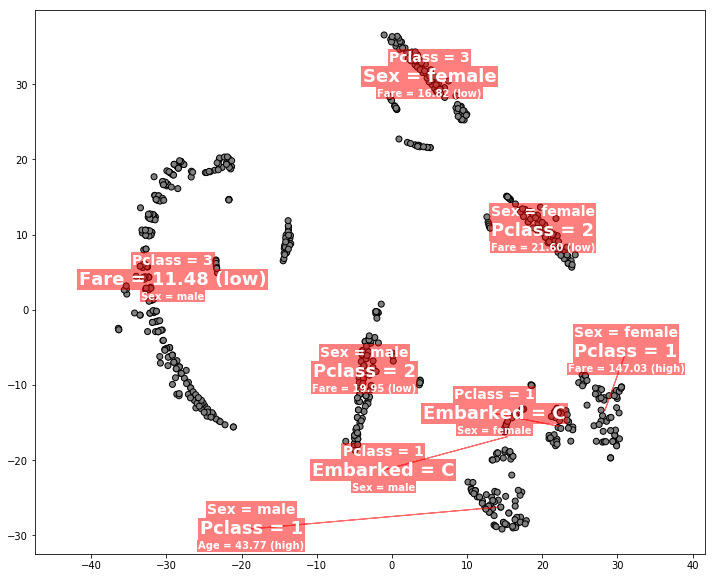

In [7]:
tab_explorer = TabExplorer(p_threshold=1e-2, min_cluster_size=30)
tab_explorer.fit(df, X_em, clusters)
fig, ax = tab_explorer.plot_static(avoid_overlaps=True)

Lahko izbiramo med eno vzorčnimi testi, kjer se vzorci v skupini primerjajo s celotno podatkovno množico (t-testi za zvezne atribute in hipergeometrični testi za diskretne vrednosti - privzeta opcija) in dvo vzorčnimi testi, kjer se primerjajo vzorci v skupini s tistimi izven skupine (t-testi za vse). Za diskretne vrednosti se vedno uporabi enostranski test, saj nas zanimajo le vrednosti, ki se pojavljajo pogosteje kot pričakovano.

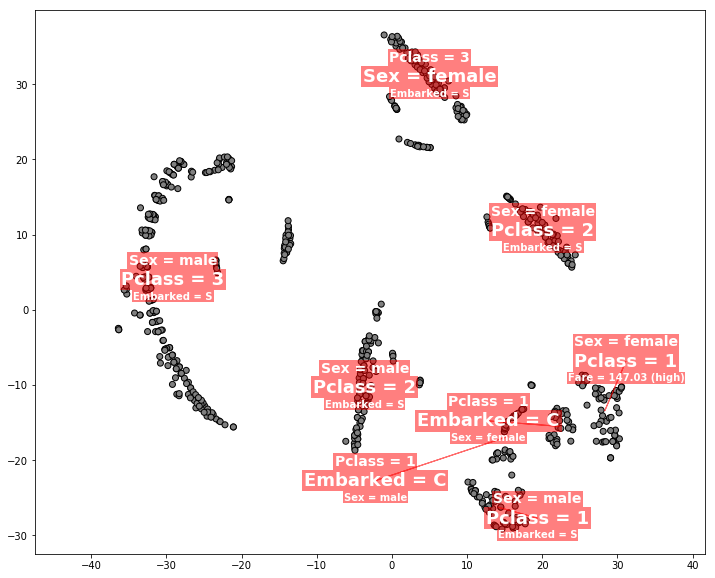

In [8]:
tab_explorer = TabExplorer(p_threshold=1e-2, use_two_sample_test=True ,min_cluster_size=30)
tab_explorer.fit(df, X_em, clusters)
fig, ax = tab_explorer.plot_static(avoid_overlaps=True)

Opazimo, da uporaba dvo vzorčnih testov med najpomembnejše atribute uvrsti precej manj zveznih atributov. V najbolj levi skupini, kjer je bila cena vozovnica z uporabo eno vzorčnih testov najpomembnejši atribut, se ta atribut niti ne uvrsti v tri z najvišjimi p-vrednostmi. 


(razišči/razmisli zakaj)
biasi tipov atribuotov:

-več kot ima diskretni atribut vrednosti, večja je verjetnost neke zelo majhne p-vrednosti (ker vzamemo min)

-splošni bias diskretnih atributov na razdalje in posledično projekcije/clustering

-uporaba enostranskih testov?

<IPython.core.display.Javascript object>


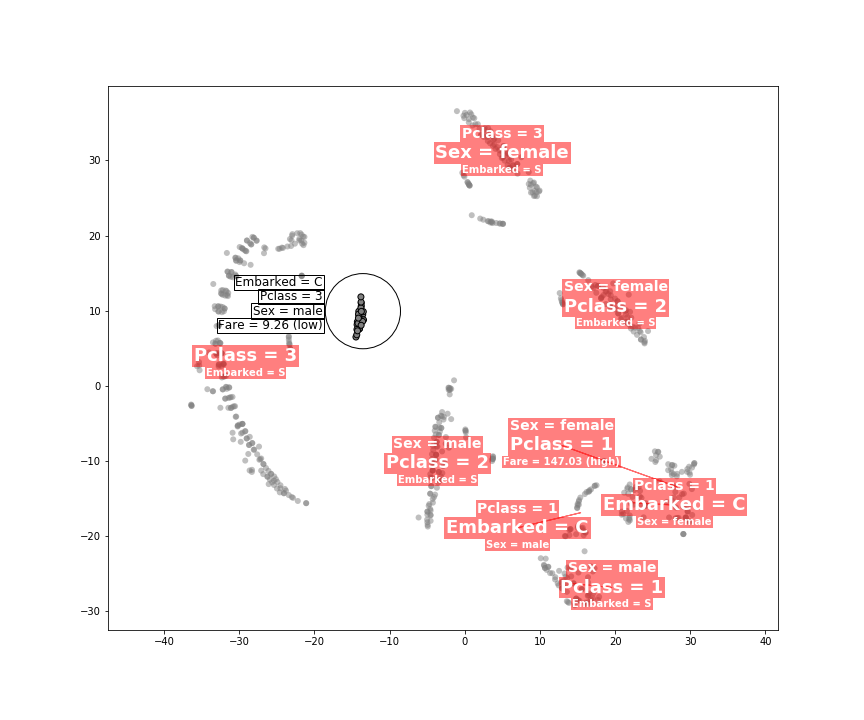

In [10]:
%matplotlib notebook

tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)
fig, ax = tab_explorer.plot_interactive()

## Alternativna metoda z uporabo mer informativnosti

Namesto statističnih testov lahko uporabimo tudi mere informativnosti (v tem primeru Gini nečistoča). Prednost tega pristopa je, da ne delamo predpostavk o porazdelitvi spremenljivk ampak primerjamo različne disktretizacije spremenljivk. Pri t-testu je to sicer pri večji količini podatkov precej manj pomembno zaradi centralnega limitnega izreka.

Še ena prednost je možnost pridobitve intervalov pri zveznih spremenljivkah. Te pridobimo z kratkvidnim pristopom kjer najprej izberemo najboljšo razdelitev in to razdelitev poizkušamo izboljšati z dodatno točko. Seveda bi pri pristopu s statističnimi testi lahko pridobili intervale zaupanja (kar je morda še bolje). 

Med pristopoma sta različni tudi obravnavi diskretnih spremenljivk. Pri prejšnjem pristopu za pridobitev p-vrednosti nekega diskretnega atributa vzamemo najmanjšo izmed p-vrednosti za vse njegove možne vrednosti. Pri tem pristopu s kratkovidno metodo (angl. greedy approach) poiščemo kombinacijo vrednosti atributa z najboljšo razliko v Gini nečistoči (Gini gain) in to uporabimo kot Gini vrednost za dan atribut. 

Največja slabost tega pristopa v primerjavi s prvotnim je izguba lepe interpretacije p-vrednosti, ki nam dajejo večjo zagotovilo o signifikantnosti napisov. 

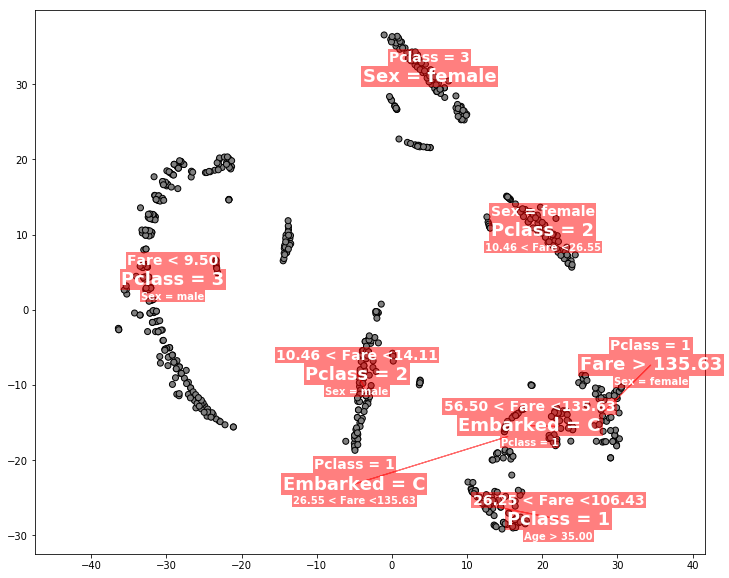

In [11]:
%matplotlib inline
gini_explorer = GiniExplorer(g_threshold=0.05, n_sample=100, min_cluster_size=30)
gini_explorer.fit(df, X_em, clusters)
fig, ax = gini_explorer.plot_static(avoid_overlaps=True)

Opazimo, da so si napisi med pristopoma precej podobni (sploh za diskretne vrednosti), kar je tudi dobra validacija pravilnosti obeh pristopov. Kljub temo, da so smeri pri zveznih atributih smiselne (če primerjamo z lower, higher pri prvotnem pristopu) so nekatere vrednosti pri tem pristopu precej oddaljene od povprečij skupin. Zanimivo bi bilo primerjati katera metoda nam da boljšo reprezentativnost.

<IPython.core.display.Javascript object>


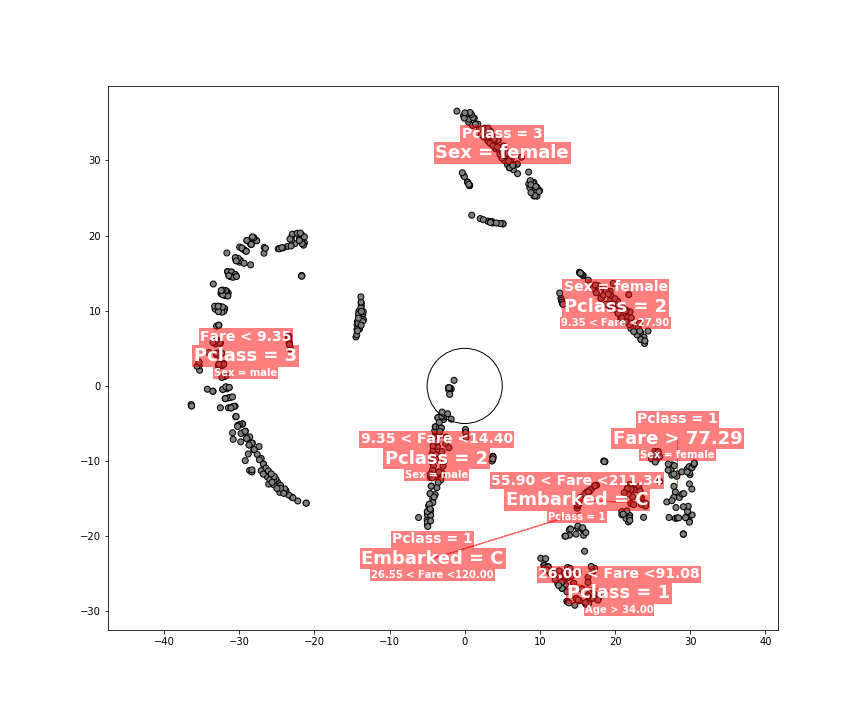

In [12]:
%matplotlib notebook

gini_explorer.fit(df, X_em, clusters)
gini_explorer.plot_static(avoid_overlaps=True)
fig, ax = gini_explorer.plot_interactive()

## Primer izračuna p-vrednosti

Primer izračuna p-vrednosti za prvo (oranžno) skupino.

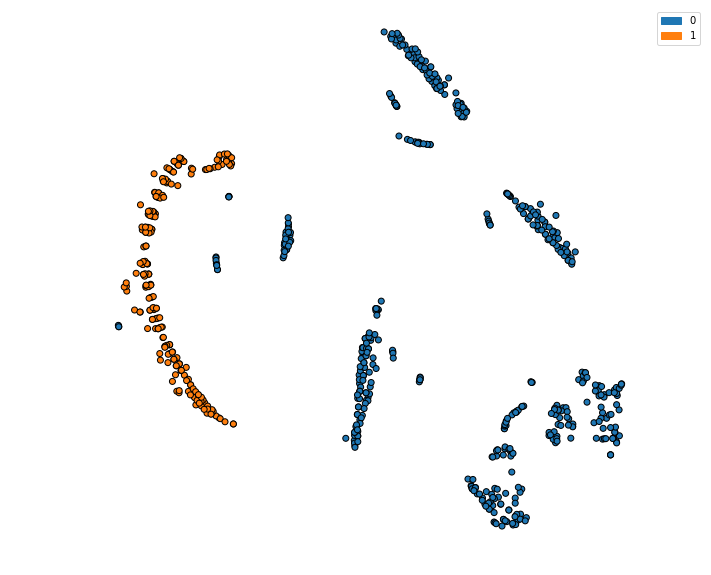

In [13]:
%matplotlib inline
is_first_cluster = clusters==0
fig,ax = tab_explorer.plot_static(classes=is_first_cluster.astype(np.int), plot_labels=False)

#save_plot('first_cluster.pdf')

Najprej prodobimo nekaj osnovnih informacij o skupini.

In [14]:
df_dummies = pd.concat([pd.get_dummies(df[col]) if df[col].dtype==object else df[col] for col in df], axis=1,
                                     keys=df.columns)
first_cluster = df_dummies.loc[is_first_cluster]
not_first_cluster = df_dummies.loc[~is_first_cluster]


print("Total dataset size: {}".format(df_dummies.shape[0])) 
print("Cluster size: {}".format(first_cluster.shape[0])) 
print("Out-cluster size: {}".format(not_first_cluster.shape[0])) 

Total dataset size: 712
Cluster size: 212
Out-cluster size: 500


Za računanje p-vrednosti so ključne porazdelitve vrednosti v skupini, izven nje ter globalne porazdelitve.

In [15]:
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=27)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=27)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=27)    # fontsize of the tick labels
#plt.rc('legend', fontsize=27)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE) 

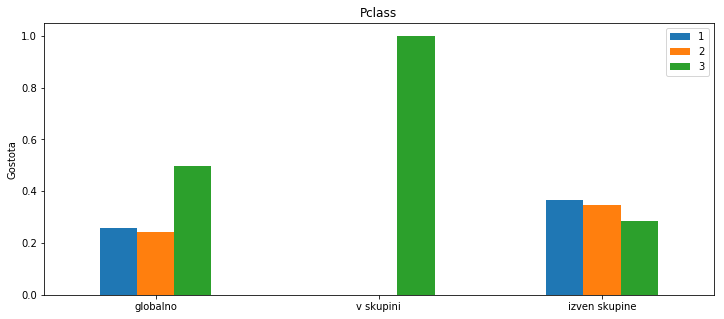

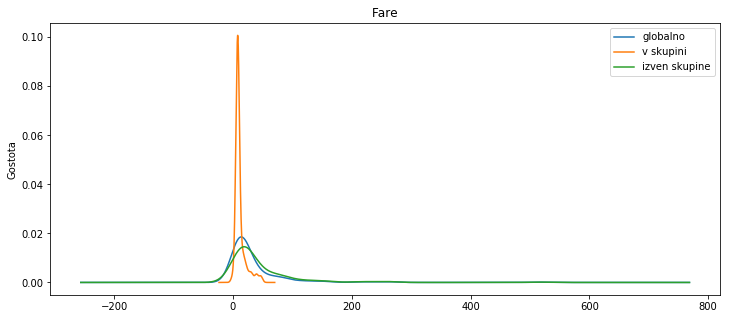

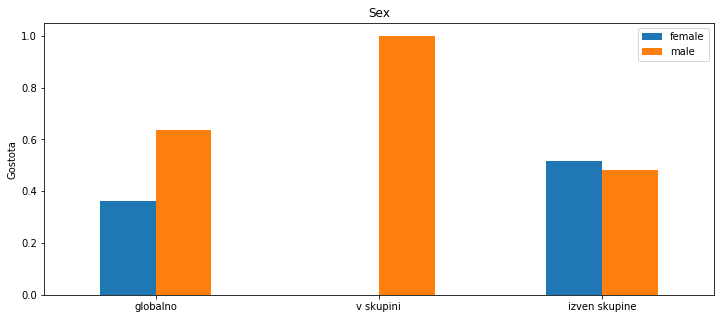

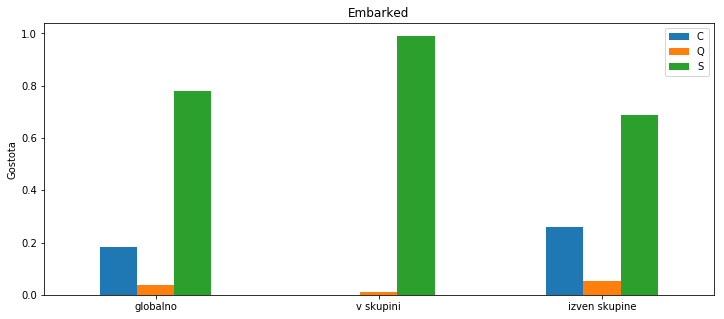

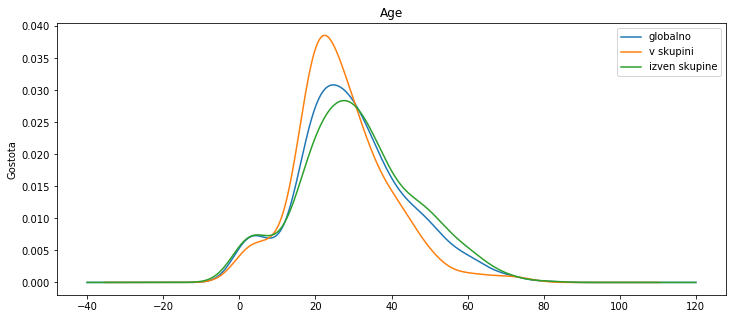

In [17]:
keys = ['globalno', 'v skupini', 'izven skupine']
dfs = [df_dummies, first_cluster, not_first_cluster]

for c in set(df_dummies.columns.get_level_values(0)):
#for c in ['Embarked', 'Age']:
    if np.issubdtype(df[c].dtype, np.number):
        kind = 'kde'
        plot_df = pd.concat([df[c] for df in dfs], axis=1, keys=keys).T.reset_index(drop=True).T
        plot_df.columns = keys
    else:
        kind = 'bar'
        plot_df = pd.DataFrame([df[c].sum()/df[c].shape[0] for df in dfs],
                          index=keys)
    
    ax = plot_df.plot(kind=kind, rot=0, figsize=(12,5), title=c)
    ax.set_ylabel('Gostota')
    plt.show()
    
    #ax.set_title("")
    #plt.sca(ax)
    #save_plot('{}.pdf'.format(c.lower()), show_axis=True)

Opazimo, da so na teh podatkih porazdelitve v skupini precej čiste, sploh za diskretne atribute kjer imajo skoraj vsi pripadniki skupine enake vrednosti. Čiste porazdelitve dobimo tudi za veliko večino ostalih skupin, saj so podatki precej preprosti.

Če prikažemo še izračune p-vrednosti, opazimo da so te v skladu z našimi ugotovitvami. Poleg očitnih vrednosti za diskretne spremenljivke opazimo, da ima starost precej višjo p-vrednost od cene vozovnice. Tudi to je skladno z zgornjimi slikami saj je porazdelitev cene vozovnic v skupini precej bolj drugačna od te izven skupine (v primerjavi s starostjo).

In [18]:
numeric_p_values = tab_explorer._numeric_p_values(is_first_cluster)
discrete_p_values = tab_explorer._discrete_p_values(is_first_cluster)

p_values = pd.concat([numeric_p_values, discrete_p_values])
p_values

Age       Age        3.891809e-04
Fare      Fare       3.523315e-29
Pclass    1          1.000000e+00
          2          1.000000e+00
          3         4.872724e-138
Sex       female     1.000000e+00
          male       2.060205e-81
Embarked  C          1.000000e+00
          Q          9.998011e-01
          S          1.777764e-38
dtype: float64

Še vedno pa se zdi p-vrednost za starost glede na vizualno podobnost porazdelitve precej nizka. Ker t-test ne primerja porazdelitve vzorcev ampak porazdelitve vzorčnih povprečij (ob predpostavki normalnosti), izrišemo še te.

In [17]:
def plot_normals(mu_sig_lab):
    for mu, sigma, label in mu_sig_lab:
        x = np.linspace(mu - 5*sigma, mu + 5*sigma, 500)
        plt.plot(x, mlab.normpdf(x, mu, sigma), label=label)
        
    plt.legend()
    plt.show()


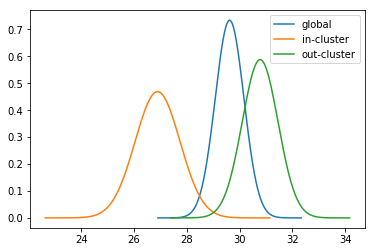

In [18]:
mu_sig_lab = [(df.Age.mean()[0], df.Age.std()[0]/np.sqrt(df.shape[0]), key) for key, df in zip(keys, dfs)]
plot_normals(mu_sig_lab)

Porazdelitve vzorčnih povprečij so si precej bolj različne. Nizka p-vrednost je torej smiselna.

## Problem večkratnih primerjanj

In [19]:
X = np.random.uniform(size=(1000,125))
clusters = np.random.randint(0,4, size=(1000,))
X_em = np.random.uniform(size=(1000, 2))
df = pd.DataFrame(X)
for i in range(25):
    df['d{}'.format(i)] = np.random.randint(0,4, size=(1000,)).astype(object)

Naključna množica podatkov brez uporabe FDR.

(<matplotlib.figure.Figure at 0x242aa6ca550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x242ac8a5c88>)

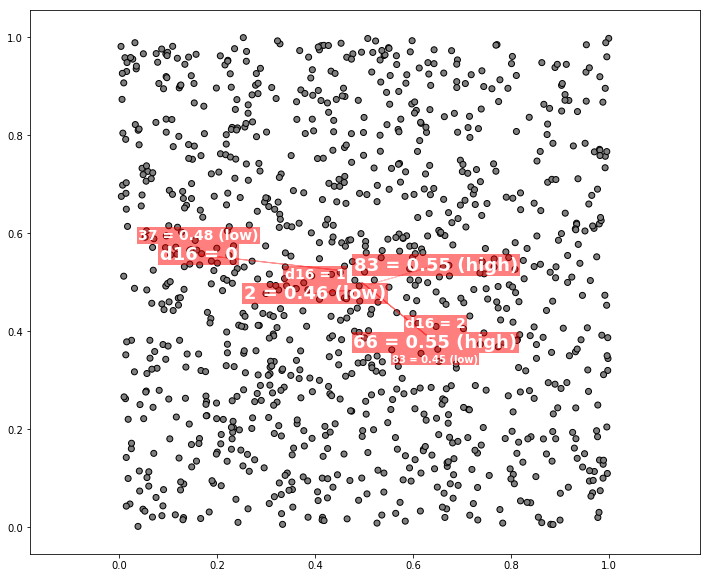

In [20]:
tab_explorer = TabExplorer(p_threshold=0.01, use_two_sample_test=True ,fdr_correction=False, representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)

Enaka naključna množica podatkov z uporabo FDR.

(<matplotlib.figure.Figure at 0x242aa88b2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x242aa645080>)

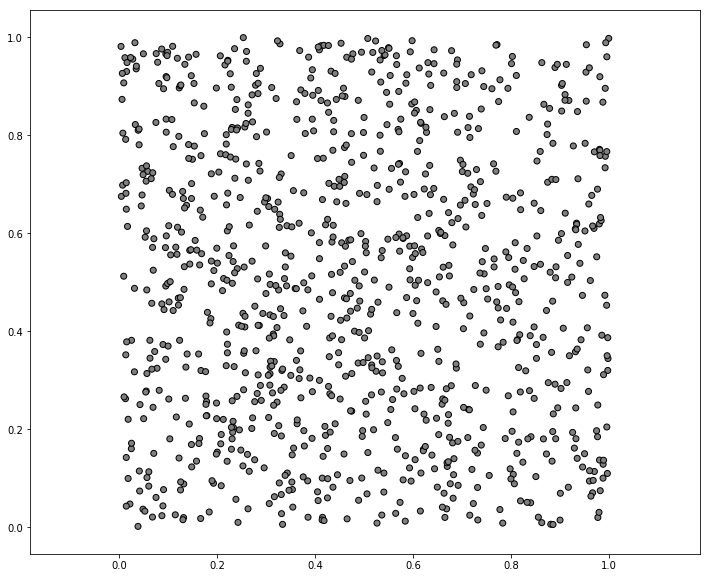

In [21]:
tab_explorer = TabExplorer(p_threshold=0.01, fdr_correction=True, representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)

## Problem: signifikantnost ni nujno reprezentativnost

Generiranje umetne podatkovne množice (diskretni atribut)

In [22]:
clusters = np.hstack((np.full(50, 1), np.full(50, 2)))
atr =  np.random.randint(0,2, size=(100,))
atr[-7:]  = 2

df = pd.DataFrame()
df['atr'] = atr.astype(object)

X_em = np.array([[c + np.random.uniform(0, 0.2) -0.1*(a==2), np.random.uniform(0, 0.2)] for a,c in zip(atr, clusters)])

Brez uporabe reprezentativnega pragu

(<matplotlib.figure.Figure at 0x242aa84b160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x242ac6c3860>)

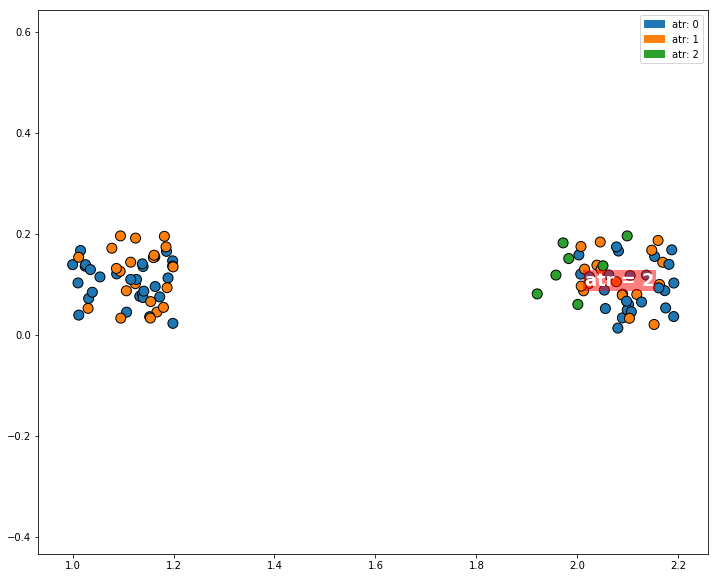

In [23]:
tab_explorer = TabExplorer(p_threshold=0.05,representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
labels = ['atr: '+ str(a) for a in atr]
tab_explorer.plot_static(avoid_overlaps=True, classes=labels, s=100)

Z uporabo reprezentativnega pragu

(<matplotlib.figure.Figure at 0x242ac68aef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x242ab8c9358>)

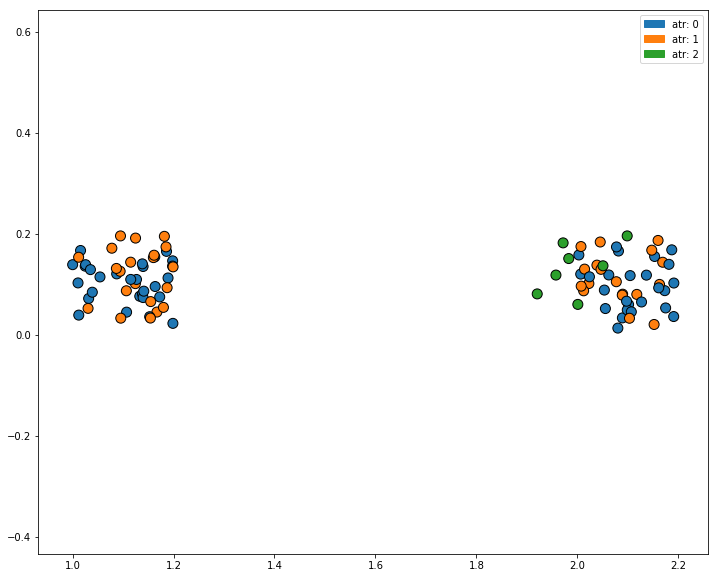

In [24]:
tab_explorer = TabExplorer(p_threshold=0.05, representative_threshold=0.5)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True, classes=labels, s=100)

Lahko bi ubrali tudi pristop kjer bi množili p-vrednosti z inverzi reprezentativnosti ampak bi s tem pokvarili interpretabilnost p-vrednosti.

Generiranje umetne podatkovne množice (zvezni atribut)

In [25]:
clusters = np.hstack((np.full(200, 1), np.full(200, 2))).astype(object)
atr =  np.random.normal(1,size=(400,))
atr[-200:] -= 0.5
atr[-20:] = 10.0

df = pd.DataFrame()
df['atr'] = atr

X_em = np.array([[c + np.random.uniform(0, 0.2), np.random.uniform(0, 0.2)] for a,c in zip(atr, clusters)])

Brez uporabe reprezentativnega pragu

(<matplotlib.figure.Figure at 0x242ac6d5470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x242aad96f28>)

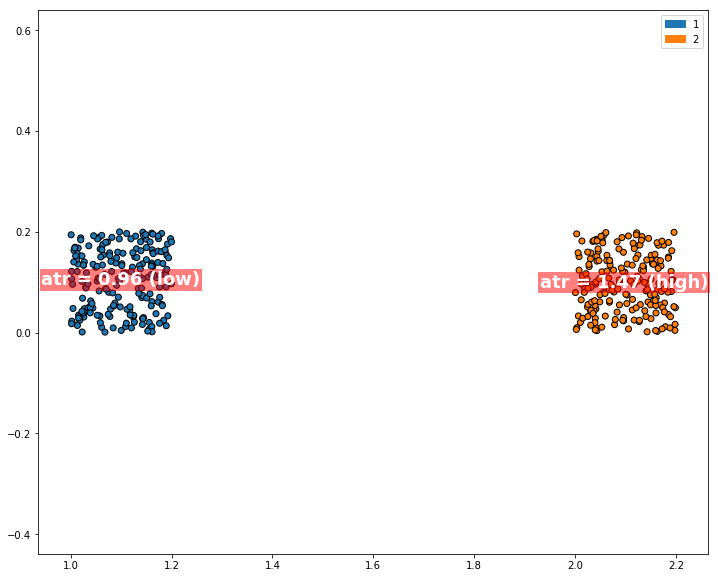

In [26]:
tab_explorer = TabExplorer(p_threshold=0.05, use_two_sample_test=True, representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True, classes = clusters)

Opazimo, da ima večino primerov iz druge skipine v resnici manjšo vrednost od primerov s prve skupine.

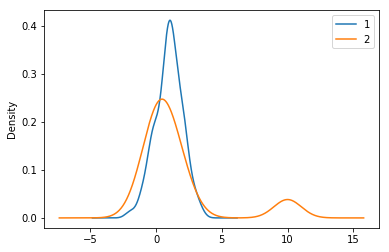

In [27]:
df['cluster'] = clusters
ax1, ax2= df.groupby('cluster').atr.plot(kind='kde', legend=True)

Z uporabo reprezentativnega pragu

(<matplotlib.figure.Figure at 0x242aacd1f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x242aafc0b38>)

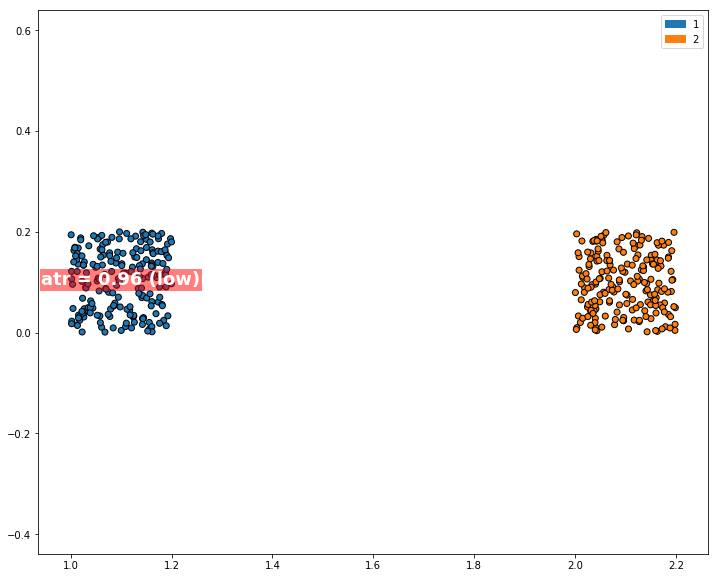

In [28]:
df.drop('cluster', axis=1, inplace=True)

tab_explorer = TabExplorer(p_threshold=0.05, representative_threshold=0.5)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True, classes = clusters)

Seveda je tu problem, da je predpostavka o normalnosti kršena, vendar pa se to lahko zgodi tudi pri resničnih podatkih. Prav tako opazimo, da uporaba pragu reprezentativnosti ni izbrisala napisa na prvi skupini. Ta problem na večjih podatkih z večimi skupinami postane manj prisoten, saj tam primerjava znotraj in zunaj skupine ni ekvivalentna primerjavi dveh skupin. 